# Japan Trade Statistics Analysis - 2020

This notebook provides a comprehensive analysis of Japan's trade statistics data.

**Data Overview:**
- Database: `input-data/ym_2020.db`
- Total Records: 862,599
- Time Period: 202001 to 202008
- Countries: 228
- HS2 Categories: 97

**Key Questions to Explore:**
1. What is Japan's trade balance (exports vs imports)?
2. Who are Japan's top trading partners?
3. What are the most traded commodities?
4. How do trade patterns change over time?
5. What are the geographic patterns in trade?


In [5]:
# Import required libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('husl')
warnings.filterwarnings('ignore')

# Display all columns in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## 1. Data Loading and Basic Exploration

In [7]:
# Load data from SQLite database
db_path = 'input-data/ym_2020.db'
table_name = 'ym_2020'

# Connect and load data
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(f'SELECT * FROM {table_name}', conn)
conn.close()

print(f'Data shape: {df.shape}')
print(f'Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB')
df.head()

Data shape: (862599, 13)
Memory usage: 273.1 MB


,index,exp_imp,Year,month,ym,Country,hs2,hs4,hs6,hs9,Q1,Q2,Value
0,0,1,2020,01,202001,205,01,0101,010121,010121000,0,2,30000
1,1,1,2020,01,202001,601,01,0101,010121,010121000,0,9,60559
2,4,1,2020,01,202001,601,01,0101,010129,010129000,0,2,7490
3,7,1,2020,01,202001,105,01,0106,010612,010612000,0,4,26188
4,10,1,2020,01,202001,103,01,0106,010619,010619000,0,6905,24236


In [8]:
# Basic data information
print('Data types and null values:')
print(df.info())
print('\nBasic statistics:')
df.describe()

Data types and null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862599 entries, 0 to 862598
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   index    862599 non-null  int64 
 1   exp_imp  862599 non-null  int64 
 2   Year     862599 non-null  int64 
 3   month    862599 non-null  object
 4   ym       862599 non-null  int64 
 5   Country  862599 non-null  int64 
 6   hs2      862599 non-null  object
 7   hs4      862599 non-null  object
 8   hs6      862599 non-null  object
 9   hs9      862599 non-null  object
 10  Q1       862599 non-null  int64 
 11  Q2       862599 non-null  int64 
 12  Value    862599 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 85.6+ MB
None

Basic statistics:


,index,exp_imp,Year,ym,Country,Q1,Q2,Value
count,862599.000000,862599.000000,862599.0,862599.000000,862599.00000,8.625990e+05,8.625990e+05,8.625990e+05
mean,6467.922468,1.424145,2020.0,202004.444293,204.21125,2.381800e+05,4.153883e+05,1.019300e+05
std,7079.941929,0.494213,0.0,2.301858,123.27078,2.452348e+07,1.835306e+07,1.286809e+06
min,0.000000,1.000000,2020.0,202001.000000,103.00000,0.000000e+00,0.000000e+00,2.010000e+02
25%,1474.000000,1.000000,2020.0,202002.000000,111.00000,0.000000e+00,1.170000e+02,1.082000e+03
50%,4064.000000,1.000000,2020.0,202004.000000,203.00000,0.000000e+00,1.250000e+03,4.943000e+03
75%,8655.000000,2.000000,2020.0,202006.000000,228.00000,9.000000e+00,1.507100e+04,2.553250e+04
max,33185.000000,2.000000,2020.0,202008.000000,702.00000,7.577265e+09,4.402701e+09,2.502828e+08


In [9]:
# Data quality checks
print('Missing values by column:')
print(df.isnull().sum())

print('\nUnique values in key categorical columns:')
for col in ['exp_imp', 'Year', 'month']:
    print(f'{col}: {sorted(df[col].unique())}')

print(f'\nYear-Month range: {df.ym.min()} to {df.ym.max()}')
print(f'Number of countries: {df.Country.nunique()}')
print(f'Number of HS2 categories: {df.hs2.nunique()}')

Missing values by column:
index      0
exp_imp    0
Year       0
month      0
ym         0
Country    0
hs2        0
hs4        0
hs6        0
hs9        0
Q1         0
Q2         0
Value      0
dtype: int64

Unique values in key categorical columns:
exp_imp: [np.int64(1), np.int64(2)]
Year: [np.int64(2020)]
month: ['01', '02', '03', '04', '05', '06', '07', '08']

Year-Month range: 202001 to 202008
Number of countries: 228
Number of HS2 categories: 97


In [10]:
# Create more readable labels
df['trade_type'] = df['exp_imp'].map({1: 'Export', 2: 'Import'})
df['year_month'] = pd.to_datetime(df['ym'].astype(str), format='%Y%m')

# Convert Value to billions of yen for easier reading
df['value_billion_yen'] = df['Value'] / 1e9

print('Trade type distribution:')
print(df['trade_type'].value_counts())
print('\nSample of processed data:')
df[['trade_type', 'year_month', 'Country', 'hs2', 'value_billion_yen', 'Q1', 'Q2']].head()

Trade type distribution:
trade_type
Export    496732
Import    365867
Name: count, dtype: int64

Sample of processed data:


,trade_type,year_month,Country,hs2,value_billion_yen,Q1,Q2
0,Export,2020-01-01,205,01,0.000030,0,2
1,Export,2020-01-01,601,01,0.000061,0,9
2,Export,2020-01-01,601,01,0.000007,0,2
3,Export,2020-01-01,105,01,0.000026,0,4
4,Export,2020-01-01,103,01,0.000024,0,6905


## 2. Trade Balance Analysis

In [11]:
# Overall trade balance
trade_summary = df.groupby('trade_type')['Value'].agg(['sum', 'count', 'mean']).round(2)
trade_summary['sum_billion_yen'] = trade_summary['sum'] / 1e9

print('Overall Trade Summary:')
print(trade_summary)

exports = trade_summary.loc['Export', 'sum']
imports = trade_summary.loc['Import', 'sum']
balance = exports - imports

print(f'\nTrade Balance:')
print(f'Total Exports: ¥{exports/1e12:.2f} trillion')
print(f'Total Imports: ¥{imports/1e12:.2f} trillion')
print(f'Trade Balance: ¥{balance/1e12:.2f} trillion ({'Surplus' if balance > 0 else 'Deficit'})')

Overall Trade Summary:
                    sum   count       mean  sum_billion_yen
trade_type                                                 
Export      42966831144  496732   86499.02        42.966831
Import      44957891838  365867  122880.42        44.957892

Trade Balance:
Total Exports: ¥0.04 trillion
Total Imports: ¥0.04 trillion
Trade Balance: ¥-0.00 trillion (Deficit)


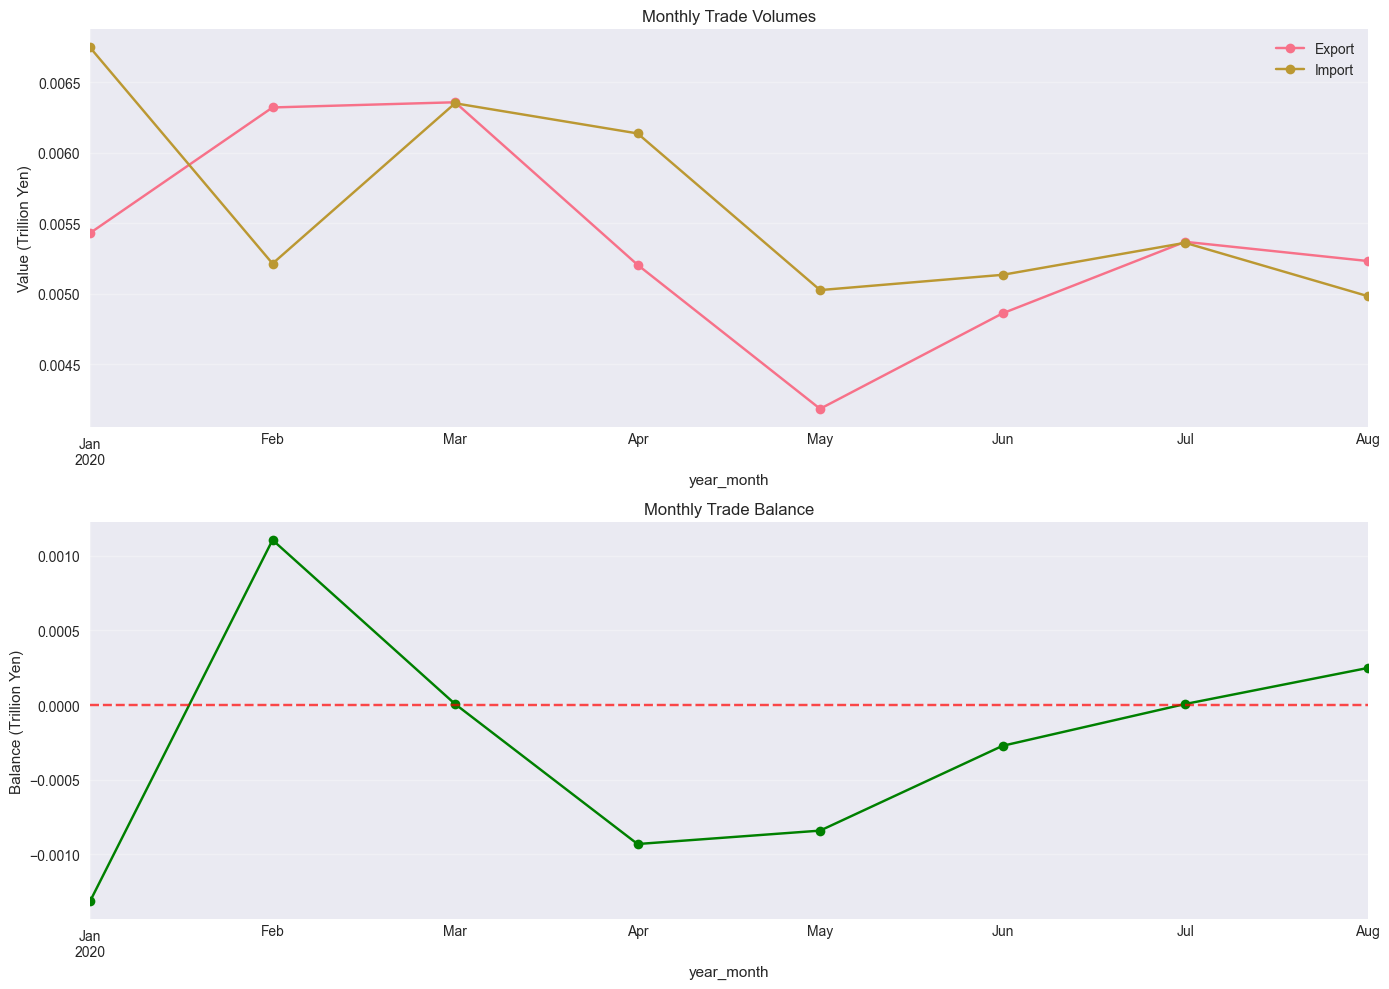

Monthly Trade Data:
trade_type  Export  Import  Balance
year_month                         
2020-01-01   0.005   0.007   -0.001
2020-02-01   0.006   0.005    0.001
2020-03-01   0.006   0.006    0.000
2020-04-01   0.005   0.006   -0.001
2020-05-01   0.004   0.005   -0.001
2020-06-01   0.005   0.005   -0.000
2020-07-01   0.005   0.005    0.000
2020-08-01   0.005   0.005    0.000


In [12]:
# Monthly trade balance
monthly_trade = df.groupby(['year_month', 'trade_type'])['Value'].sum().unstack()
monthly_trade['Balance'] = monthly_trade['Export'] - monthly_trade['Import']
monthly_trade = monthly_trade / 1e12  # Convert to trillions

# Plot monthly trade
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Trade volumes
monthly_trade[['Export', 'Import']].plot(kind='line', ax=ax1, marker='o')
ax1.set_title('Monthly Trade Volumes')
ax1.set_ylabel('Value (Trillion Yen)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Trade balance
monthly_trade['Balance'].plot(kind='line', ax=ax2, marker='o', color='green')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
ax2.set_title('Monthly Trade Balance')
ax2.set_ylabel('Balance (Trillion Yen)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Monthly Trade Data:')
print(monthly_trade.round(3))

## 3. Top Trading Partners Analysis

In [13]:
# Top trading partners by total trade value
partner_trade = df.groupby(['Country', 'trade_type'])['Value'].sum().unstack(fill_value=0)
partner_trade['Total'] = partner_trade['Export'] + partner_trade['Import']
partner_trade['Balance'] = partner_trade['Export'] - partner_trade['Import']
partner_trade = partner_trade.sort_values('Total', ascending=False)

# Convert to billions for display
partner_display = partner_trade.copy()
for col in ['Export', 'Import', 'Total', 'Balance']:
    partner_display[col] = partner_display[col] / 1e9

print('Top 15 Trading Partners (Billions of Yen):')
print(partner_display.head(15).round(2))

Top 15 Trading Partners (Billions of Yen):
trade_type  Export  Import  Total  Balance
Country                                   
105           9.37   11.26  20.62    -1.89
304           7.72    5.09  12.81     2.64
106           3.08    1.89   4.98     1.19
103           3.06    1.87   4.94     1.19
601           0.79    2.60   3.40    -1.81
111           1.69    1.65   3.33     0.04
213           1.19    1.51   2.69    -0.32
110           1.14    1.53   2.67    -0.39
108           2.19    0.05   2.24     2.14
113           0.84    1.14   1.98    -0.30
112           1.24    0.64   1.88     0.60
118           0.66    1.10   1.77    -0.44
147           0.38    1.23   1.61    -0.85
137           0.29    1.32   1.61    -1.03
302           0.46    0.77   1.23    -0.31


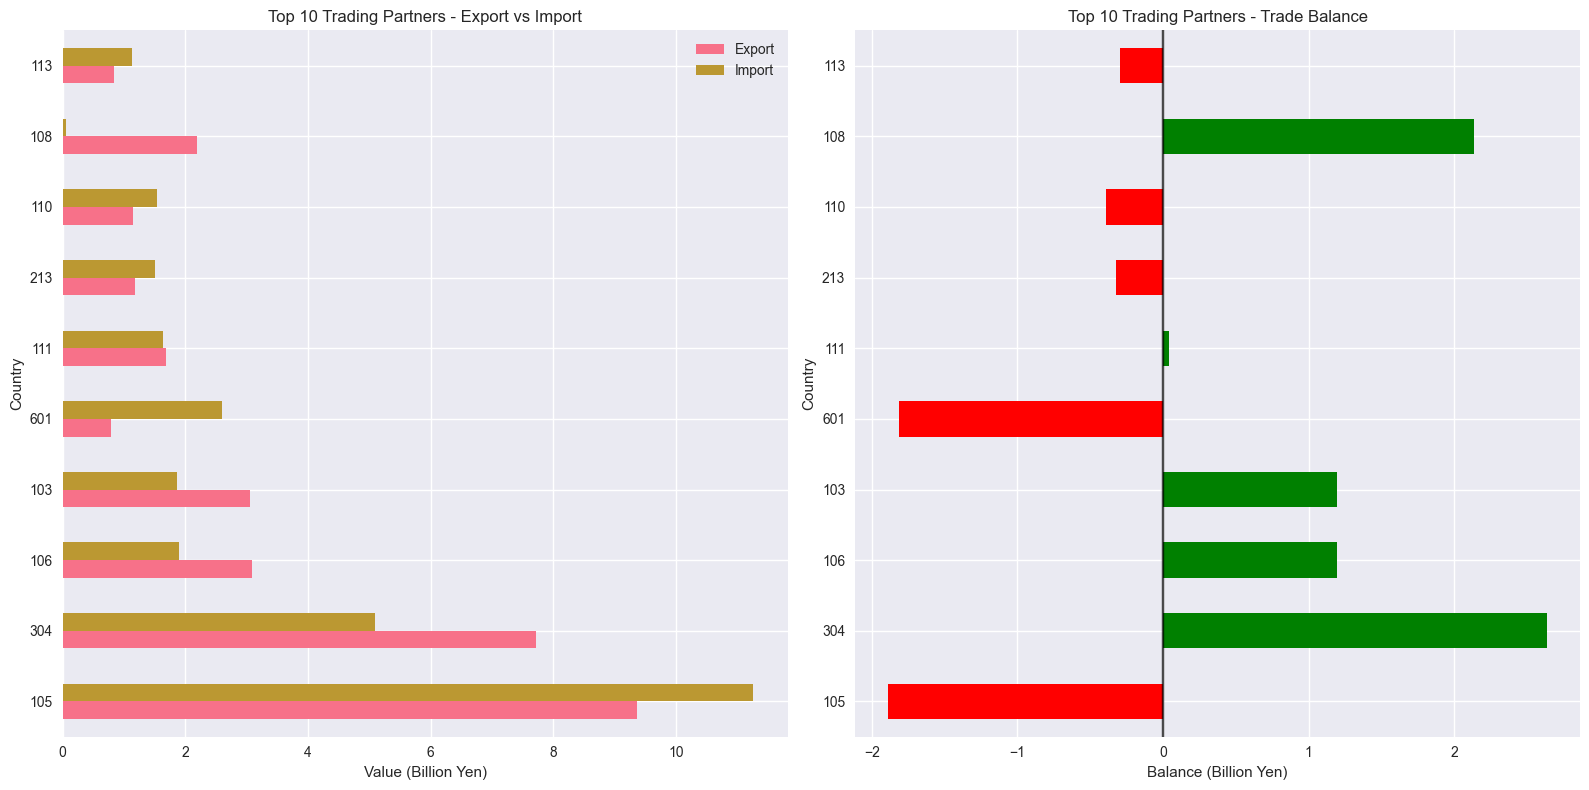

In [14]:
# Visualize top trading partners
top_partners = partner_display.head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Trade volumes
top_partners[['Export', 'Import']].plot(kind='barh', ax=ax1)
ax1.set_title('Top 10 Trading Partners - Export vs Import')
ax1.set_xlabel('Value (Billion Yen)')
ax1.legend()

# Trade balance
colors = ['green' if x > 0 else 'red' for x in top_partners['Balance']]
top_partners['Balance'].plot(kind='barh', ax=ax2, color=colors)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.7)
ax2.set_title('Top 10 Trading Partners - Trade Balance')
ax2.set_xlabel('Balance (Billion Yen)')

plt.tight_layout()
plt.show()

## 4. Commodity Analysis (HS Codes)

In [15]:
# HS2 level analysis (major categories)
hs2_trade = df.groupby(['hs2', 'trade_type'])['Value'].sum().unstack(fill_value=0)
hs2_trade['Total'] = hs2_trade['Export'] + hs2_trade['Import']
hs2_trade['Balance'] = hs2_trade['Export'] - hs2_trade['Import']
hs2_trade = hs2_trade.sort_values('Total', ascending=False)

# Convert to billions
hs2_display = hs2_trade.copy()
for col in ['Export', 'Import', 'Total', 'Balance']:
    hs2_display[col] = hs2_display[col] / 1e9

print('Top 15 HS2 Categories by Total Trade (Billions of Yen):')
print(hs2_display.head(15).round(2))

Top 15 HS2 Categories by Total Trade (Billions of Yen):
trade_type  Export  Import  Total  Balance
hs2                                       
85            6.84    6.47  13.31     0.37
84            8.29    4.75  13.03     3.54
87            7.66    1.30   8.96     6.36
27            0.61    7.92   8.53    -7.31
90            2.53    1.80   4.33     0.73
00            2.68    0.74   3.42     1.93
39            1.70    1.08   2.78     0.63
30            0.52    2.08   2.61    -1.56
29            1.05    1.15   2.20    -0.10
72            1.64    0.42   2.06     1.22
71            0.91    1.03   1.94    -0.12
26            0.01    1.47   1.48    -1.45
38            0.82    0.45   1.27     0.38
73            0.64    0.48   1.12     0.16
28            0.45    0.43   0.88     0.02


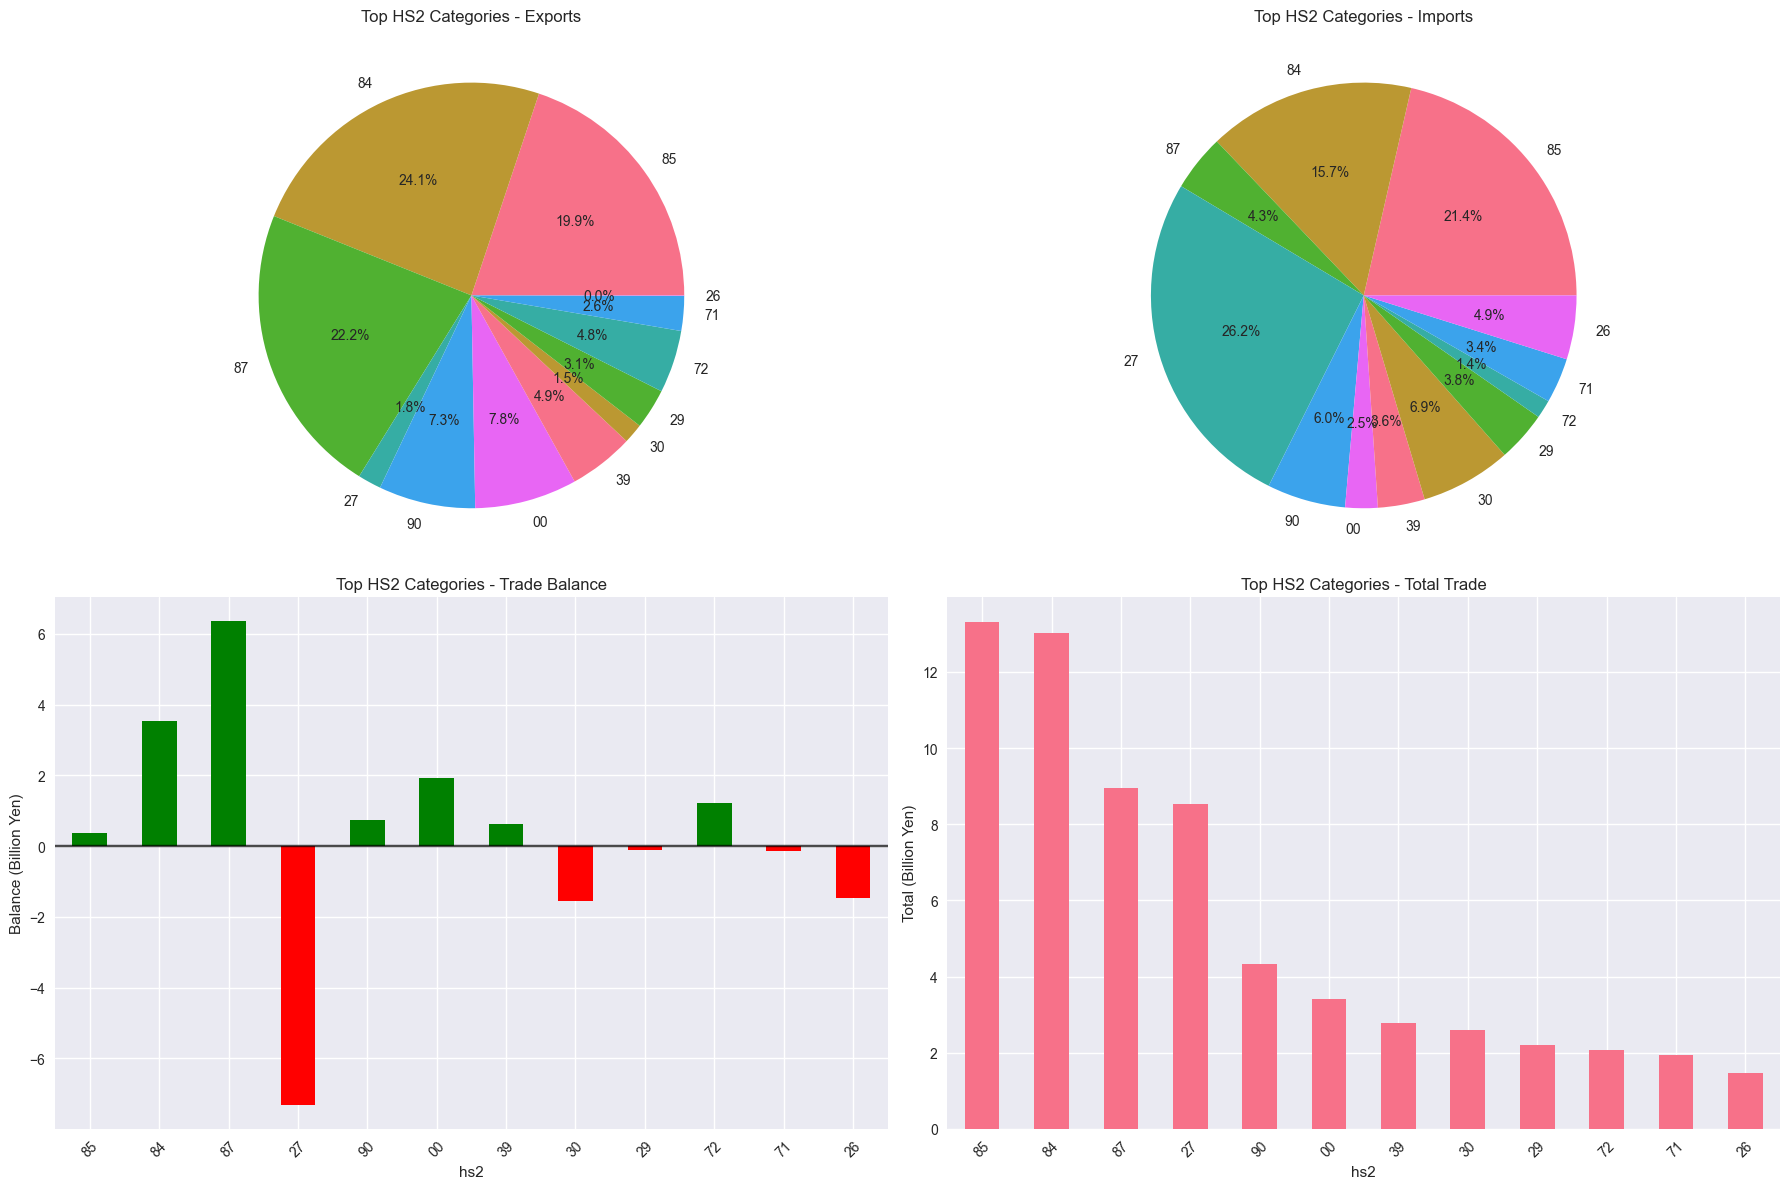

In [16]:
# Visualize top HS2 categories
top_hs2 = hs2_display.head(12)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Export pie chart
top_hs2['Export'].plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Top HS2 Categories - Exports')
ax1.set_ylabel('')

# Import pie chart
top_hs2['Import'].plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Top HS2 Categories - Imports')
ax2.set_ylabel('')

# Trade balance bar chart
colors = ['green' if x > 0 else 'red' for x in top_hs2['Balance']]
top_hs2['Balance'].plot(kind='bar', ax=ax3, color=colors)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.7)
ax3.set_title('Top HS2 Categories - Trade Balance')
ax3.set_ylabel('Balance (Billion Yen)')
ax3.tick_params(axis='x', rotation=45)

# Total trade bar chart
top_hs2['Total'].plot(kind='bar', ax=ax4)
ax4.set_title('Top HS2 Categories - Total Trade')
ax4.set_ylabel('Total (Billion Yen)')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Time Series Analysis

In [17]:
# Monthly trends by trade type
monthly_trends = df.groupby(['year_month', 'trade_type'])['Value'].agg(['sum', 'count', 'mean'])
monthly_trends.columns = ['Total_Value', 'Count', 'Avg_Value']
monthly_trends = monthly_trends.reset_index()

# Pivot for easier plotting
monthly_pivot = monthly_trends.pivot(index='year_month', columns='trade_type', values='Total_Value')
monthly_pivot = monthly_pivot / 1e12  # Convert to trillions

print('Monthly Trade Trends (Trillion Yen):')
print(monthly_pivot.round(3))

Monthly Trade Trends (Trillion Yen):
trade_type  Export  Import
year_month                
2020-01-01   0.005   0.007
2020-02-01   0.006   0.005
2020-03-01   0.006   0.006
2020-04-01   0.005   0.006
2020-05-01   0.004   0.005
2020-06-01   0.005   0.005
2020-07-01   0.005   0.005
2020-08-01   0.005   0.005


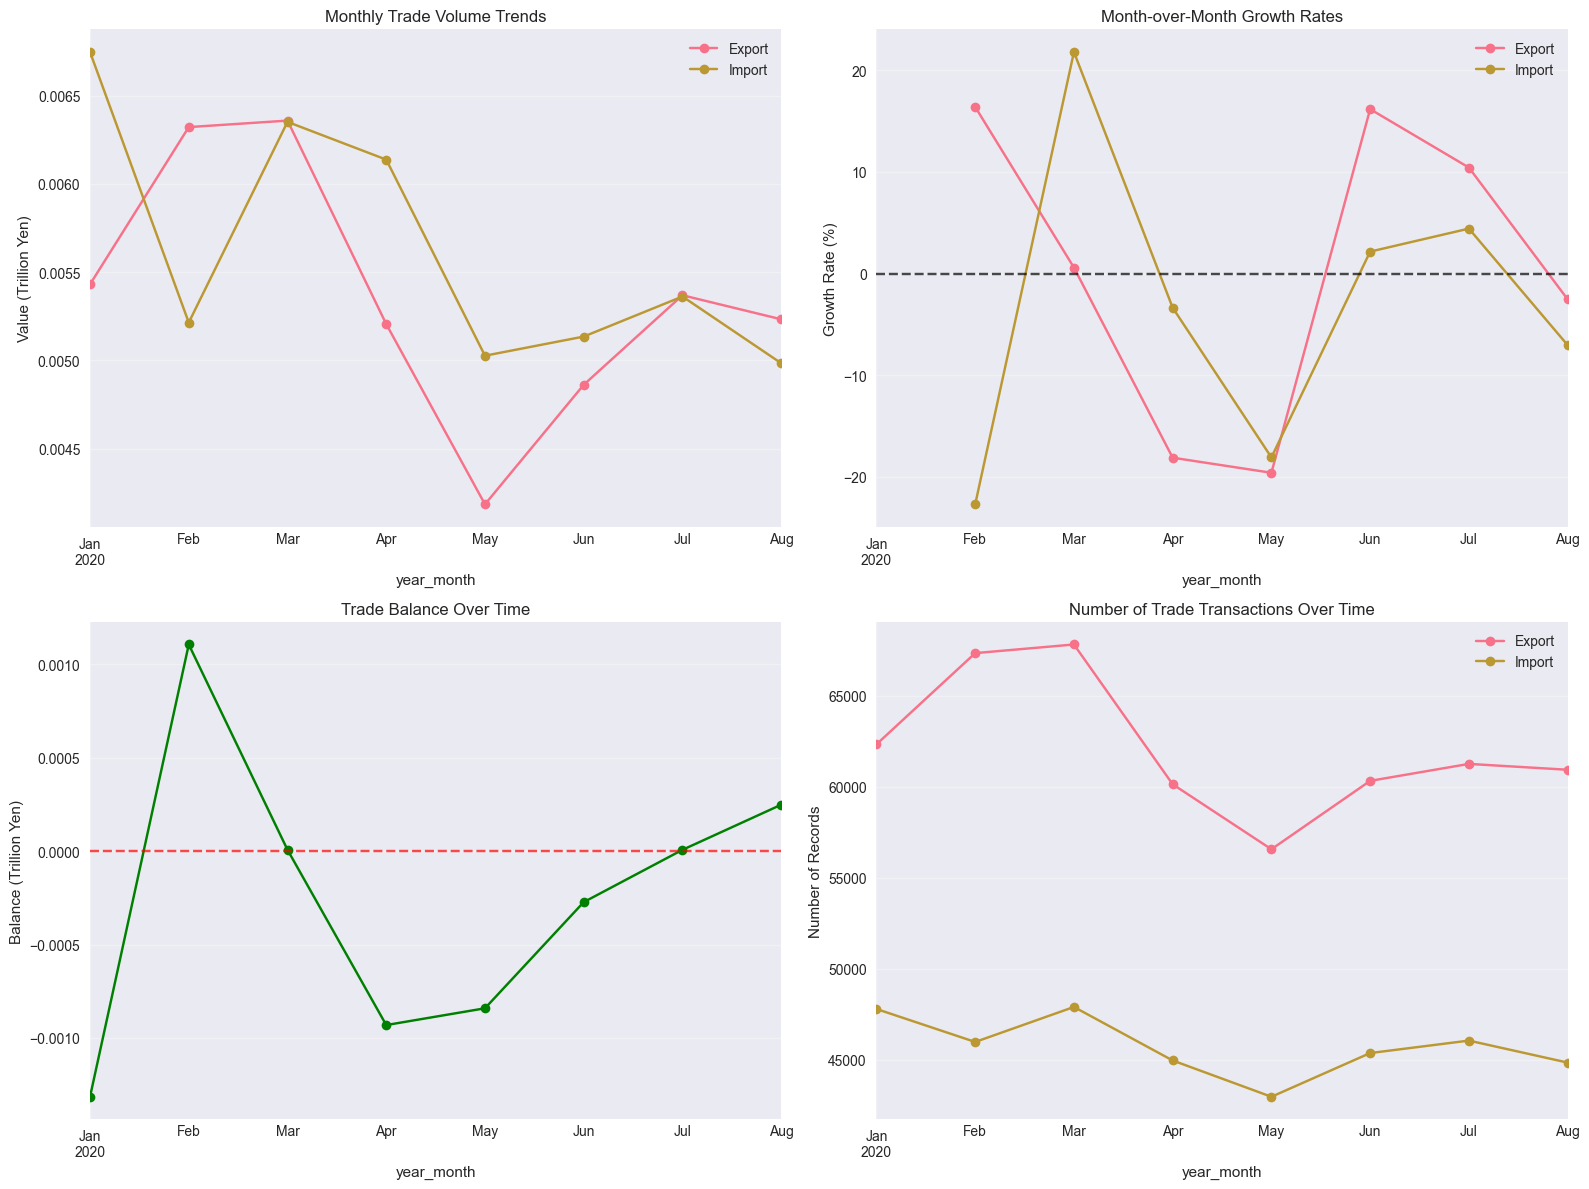

In [18]:
# Advanced time series visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Monthly volume trends
monthly_pivot.plot(ax=axes[0,0], marker='o')
axes[0,0].set_title('Monthly Trade Volume Trends')
axes[0,0].set_ylabel('Value (Trillion Yen)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Growth rates (if multiple months available)
if len(monthly_pivot) > 1:
    growth_rates = monthly_pivot.pct_change() * 100
    growth_rates.plot(ax=axes[0,1], marker='o')
    axes[0,1].set_title('Month-over-Month Growth Rates')
    axes[0,1].set_ylabel('Growth Rate (%)')
    axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.7)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
else:
    axes[0,1].text(0.5, 0.5, 'Insufficient data for growth rates', 
                   ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Growth Rates (Insufficient Data)')

# Trade balance over time
balance_series = monthly_pivot['Export'] - monthly_pivot['Import']
balance_series.plot(ax=axes[1,0], marker='o', color='green')
axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1,0].set_title('Trade Balance Over Time')
axes[1,0].set_ylabel('Balance (Trillion Yen)')
axes[1,0].grid(True, alpha=0.3)

# Number of transactions over time
monthly_count = monthly_trends.pivot(index='year_month', columns='trade_type', values='Count')
monthly_count.plot(ax=axes[1,1], marker='o')
axes[1,1].set_title('Number of Trade Transactions Over Time')
axes[1,1].set_ylabel('Number of Records')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Geographic Patterns

Trade Concentration Analysis:
Top 5 countries account for 53.2% of total trade
Top 10 countries account for 67.9% of total trade
Top 20 countries account for 83.4% of total trade


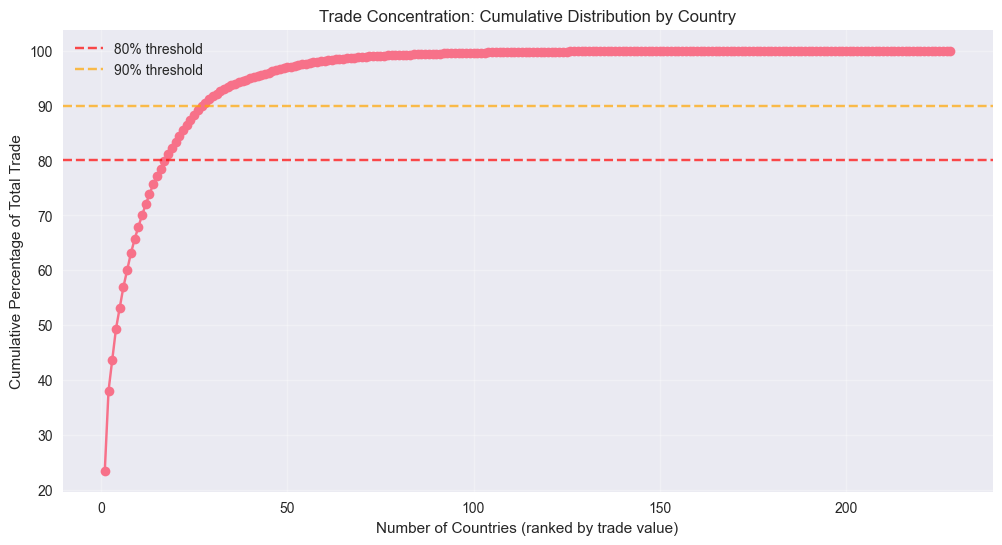

In [19]:
# Country concentration analysis
country_stats = df.groupby('Country')['Value'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
country_stats['cum_sum'] = country_stats['sum'].cumsum()
country_stats['cum_pct'] = country_stats['cum_sum'] / country_stats['sum'].sum() * 100

print('Trade Concentration Analysis:')
print(f'Top 5 countries account for {country_stats.iloc[4]["cum_pct"]:.1f}% of total trade')
print(f'Top 10 countries account for {country_stats.iloc[9]["cum_pct"]:.1f}% of total trade')
print(f'Top 20 countries account for {country_stats.iloc[19]["cum_pct"]:.1f}% of total trade')

# Plot concentration curve
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(country_stats)+1), country_stats['cum_pct'], marker='o')
plt.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% threshold')
plt.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
plt.xlabel('Number of Countries (ranked by trade value)')
plt.ylabel('Cumulative Percentage of Total Trade')
plt.title('Trade Concentration: Cumulative Distribution by Country')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Advanced Analysis Functions

In [20]:
def analyze_country_detail(country_code, top_n=10):
    """Analyze trade details for a specific country."""
    country_data = df[df['Country'] == country_code]
    
    if len(country_data) == 0:
        print(f'No data found for country code {country_code}')
        return
    
    print(f'\nDetailed Analysis for Country {country_code}:')
    print(f'Total records: {len(country_data):,}')
    
    # Trade summary
    trade_summary = country_data.groupby('trade_type')['Value'].agg(['sum', 'count'])
    print('\nTrade Summary:')
    print(trade_summary)
    
    # Top commodities
    top_commodities = country_data.groupby(['hs2', 'trade_type'])['Value'].sum().unstack(fill_value=0)
    top_commodities['Total'] = top_commodities.sum(axis=1)
    top_commodities = top_commodities.sort_values('Total', ascending=False).head(top_n)
    
    print(f'\nTop {top_n} HS2 Categories:')
    print((top_commodities / 1e9).round(2))  # In billions
    
    return country_data

def analyze_commodity_detail(hs2_code, top_n=10):
    """Analyze trade details for a specific HS2 commodity category."""
    commodity_data = df[df['hs2'] == hs2_code]
    
    if len(commodity_data) == 0:
        print(f'No data found for HS2 code {hs2_code}')
        return
    
    print(f'\nDetailed Analysis for HS2 Category {hs2_code}:')
    print(f'Total records: {len(commodity_data):,}')
    
    # Trade summary
    trade_summary = commodity_data.groupby('trade_type')['Value'].agg(['sum', 'count'])
    print('\nTrade Summary:')
    print(trade_summary)
    
    # Top countries
    top_countries = commodity_data.groupby(['Country', 'trade_type'])['Value'].sum().unstack(fill_value=0)
    top_countries['Total'] = top_countries.sum(axis=1)
    top_countries = top_countries.sort_values('Total', ascending=False).head(top_n)
    
    print(f'\nTop {top_n} Countries:')
    print((top_countries / 1e9).round(2))  # In billions
    
    return commodity_data

# Example usage:
print('Analysis functions defined. Example usage:')
print('analyze_country_detail(213)  # Analyze specific country')
print('analyze_commodity_detail("84")  # Analyze specific HS2 category')

Analysis functions defined. Example usage:
analyze_country_detail(213)  # Analyze specific country
analyze_commodity_detail("84")  # Analyze specific HS2 category


## 8. Key Insights and Summary

In [21]:
# Generate key insights
total_trade = df['Value'].sum()
export_share = df[df['trade_type'] == 'Export']['Value'].sum() / total_trade * 100
import_share = df[df['trade_type'] == 'Import']['Value'].sum() / total_trade * 100

top_partner = partner_display.index[0]
top_partner_share = partner_display.iloc[0]['Total'] / (total_trade / 1e9) * 100

top_commodity = hs2_display.index[0]
top_commodity_share = hs2_display.iloc[0]['Total'] / (total_trade / 1e9) * 100

print('KEY INSIGHTS:')
print('=' * 50)
print(f'📊 Total Trade Value: ¥{total_trade/1e12:.2f} trillion')
print(f'📈 Export Share: {export_share:.1f}%')
print(f'📉 Import Share: {import_share:.1f}%')
print(f'🤝 Top Trading Partner: Country {top_partner} ({top_partner_share:.1f}% of total trade)')
print(f'📦 Top Commodity Category: HS2-{top_commodity} ({top_commodity_share:.1f}% of total trade)')
print(f'🌍 Number of Trading Partners: {df.Country.nunique()}')
print(f'📅 Time Period Covered: {df.ym.min()} to {df.ym.max()}')

# Trade balance assessment
if export_share > import_share:
    print(f'💰 Trade Status: SURPLUS (Exports exceed imports by {export_share - import_share:.1f}%)')
else:
    print(f'⚠️ Trade Status: DEFICIT (Imports exceed exports by {import_share - export_share:.1f}%)')

print('\n🔍 For detailed analysis of specific countries or commodities, use:')
print('   analyze_country_detail(country_code)')
print('   analyze_commodity_detail(hs2_code)')

KEY INSIGHTS:
📊 Total Trade Value: ¥0.09 trillion
📈 Export Share: 48.9%
📉 Import Share: 51.1%
🤝 Top Trading Partner: Country 105 (23.5% of total trade)
📦 Top Commodity Category: HS2-85 (15.1% of total trade)
🌍 Number of Trading Partners: 228
📅 Time Period Covered: 202001 to 202008
⚠️ Trade Status: DEFICIT (Imports exceed exports by 2.3%)

🔍 For detailed analysis of specific countries or commodities, use:
   analyze_country_detail(country_code)
   analyze_commodity_detail(hs2_code)


## 9. Next Steps and Further Analysis

This notebook provides a comprehensive overview of the trade data. Here are some suggestions for deeper analysis:

### 🔬 Advanced Analytics
1. **Seasonal Analysis**: Compare trade patterns across different months
2. **Product Complexity**: Analyze trade in high-tech vs. raw materials
3. **Trade Intensity**: Calculate trade intensity ratios with major partners
4. **Market Concentration**: Use Herfindahl-Hirschman Index for market concentration

### 📈 Statistical Analysis
1. **Correlation Analysis**: Find relationships between different trade variables
2. **Outlier Detection**: Identify unusual trade transactions
3. **Trend Analysis**: Fit trend lines and forecast future trade
4. **Clustering**: Group countries or commodities by trade patterns

### 🌐 External Data Integration
1. **GDP Data**: Compare trade values with country GDP
2. **Distance/Geography**: Analyze trade by geographic distance
3. **Economic Indicators**: Correlate with global economic indicators
4. **Exchange Rates**: Adjust values for currency fluctuations

### 📊 Interactive Visualizations
1. **Plotly/Dash**: Create interactive dashboards
2. **Geographic Maps**: Plot trade flows on world maps
3. **Network Analysis**: Visualize trade networks
4. **Time Series Forecasting**: Predict future trade patterns

### 💾 Data Processing
1. **Data Validation**: Cross-check with official statistics
2. **Data Cleaning**: Handle missing values and outliers
3. **Data Enrichment**: Add country names, HS code descriptions
4. **Performance Optimization**: Optimize queries for large datasets
